In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Conv1D,MaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = [224, 224]

train_path = 'Downloads/COVID_19/train'
valid_path = 'Downloads/COVID_19/test'

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
training_covid_generator = train_datagen.flow_from_directory('Downloads/COVID_19/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 shuffle=False,
                                                 class_mode = 'binary')

Found 1028 images belonging to 2 classes.


In [8]:
train_covid_generator = train_datagen.flow_from_directory(
    'Downloads/COVID_19/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)


Found 1028 images belonging to 2 classes.


In [9]:
test_covid_generator = test_datagen.flow_from_directory(
    'Downloads/COVID_19/test',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

Found 450 images belonging to 2 classes.


In [10]:
train_non_covid_generator = train_datagen.flow_from_directory(
    'Downloads/COVID_19/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)


Found 1028 images belonging to 2 classes.


In [11]:
test_non_covid_generator = test_datagen.flow_from_directory(
    'Downloads/COVID_19/test',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

Found 450 images belonging to 2 classes.


In [12]:
# E-NET Model (CNN)
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x28f11fb20>>

In [15]:
history = model.fit(
    train_covid_generator,
    steps_per_epoch=len(train_covid_generator),
    epochs=10,
    validation_data=test_covid_generator,
    validation_steps=len(test_covid_generator)
)

Epoch 1/10
33/33 [==============================] - 9s 273ms/step - loss: 0.5453 - accuracy: 0.9553 - val_loss: 1.7006 - val_accuracy: 0.5489
Epoch 2/10
33/33 [==============================] - 9s 254ms/step - loss: 0.1976 - accuracy: 0.9553 - val_loss: 1.5145 - val_accuracy: 0.5489
Epoch 3/10
33/33 [==============================] - 9s 258ms/step - loss: 0.1901 - accuracy: 0.9553 - val_loss: 1.7448 - val_accuracy: 0.5489
Epoch 4/10
33/33 [==============================] - 9s 263ms/step - loss: 0.2013 - accuracy: 0.9553 - val_loss: 1.4832 - val_accuracy: 0.5489
Epoch 5/10
33/33 [==============================] - 9s 269ms/step - loss: 0.1927 - accuracy: 0.9553 - val_loss: 1.4201 - val_accuracy: 0.5489
Epoch 6/10
33/33 [==============================] - 9s 269ms/step - loss: 0.1912 - accuracy: 0.9553 - val_loss: 1.0789 - val_accuracy: 0.5489
Epoch 7/10
33/33 [==============================] - 9s 271ms/step - loss: 0.1970 - accuracy: 0.9553 - val_loss: 1.4900 - val_accuracy: 0.5489
Epoch 

In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


In [17]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [18]:
for layer in inception_model.layers:
    layer.trainable = False

# Add custom classifier layers
x = GlobalAveragePooling2D()(inception_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


In [19]:
inception_model_final = Model(inputs=inception_model.input, outputs=predictions)

# Compile the model
inception_model_final.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])


In [20]:
inception_model_final.fit(
    train_covid_generator,
    steps_per_epoch=len(train_covid_generator),
    epochs=5,
    validation_data=test_covid_generator,
    validation_steps=len(test_covid_generator)
)

Epoch 1/5
33/33 [==============================] - 29s 832ms/step - loss: 0.2704 - accuracy: 0.9533 - val_loss: 1.0400 - val_accuracy: 0.5489
Epoch 2/5
33/33 [==============================] - 77s 2s/step - loss: 0.1736 - accuracy: 0.9553 - val_loss: 1.8260 - val_accuracy: 0.5489
Epoch 3/5
33/33 [==============================] - 27s 811ms/step - loss: 0.1589 - accuracy: 0.9553 - val_loss: 1.0413 - val_accuracy: 0.5489
Epoch 4/5
33/33 [==============================] - 27s 819ms/step - loss: 0.1500 - accuracy: 0.9553 - val_loss: 1.0390 - val_accuracy: 0.5489
Epoch 5/5
33/33 [==============================] - 27s 832ms/step - loss: 0.1486 - accuracy: 0.9553 - val_loss: 1.3431 - val_accuracy: 0.5489


# ResNet34 Model

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [22]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [23]:
for layer in resnet_model.layers:
    layer.trainable = False

# Add custom classifier layers
x = GlobalAveragePooling2D()(resnet_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


In [24]:
resnet_model_final = Model(inputs=resnet_model.input, outputs=predictions)

# Compile the model
resnet_model_final.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

In [25]:
resnet_model_final.fit(
    train_covid_generator,
    steps_per_epoch=len(train_covid_generator),
    epochs=5,
    validation_data=test_covid_generator,
    validation_steps=len(test_covid_generator)
)

Epoch 1/5
33/33 [==============================] - 42s 1s/step - loss: 0.2312 - accuracy: 0.9319 - val_loss: 1.1802 - val_accuracy: 0.5489
Epoch 2/5
33/33 [==============================] - 68s 2s/step - loss: 0.1917 - accuracy: 0.9553 - val_loss: 1.6210 - val_accuracy: 0.5489
Epoch 3/5
33/33 [==============================] - 41s 1s/step - loss: 0.1846 - accuracy: 0.9553 - val_loss: 1.5617 - val_accuracy: 0.5489
Epoch 4/5
33/33 [==============================] - 42s 1s/step - loss: 0.1822 - accuracy: 0.9553 - val_loss: 1.8349 - val_accuracy: 0.5489
Epoch 5/5
33/33 [==============================] - 42s 1s/step - loss: 0.1908 - accuracy: 0.9553 - val_loss: 1.4898 - val_accuracy: 0.5489


# DenseNet201 Model

In [26]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load DenseNet201 pre-trained model
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [27]:
for layer in densenet_model.layers:
    layer.trainable = False


In [28]:
x = GlobalAveragePooling2D()(densenet_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create DenseNet201 model
densenet_model_final = Model(inputs=densenet_model.input, outputs=predictions)

# Compile the model
densenet_model_final.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])


In [29]:
# Train the model
densenet_model_final.fit(
    train_covid_generator,
    steps_per_epoch=len(train_covid_generator),
    epochs=5,
    validation_data=test_covid_generator,
    validation_steps=len(test_covid_generator)
)

Epoch 1/5
33/33 [==============================] - 61s 2s/step - loss: 0.2350 - accuracy: 0.9358 - val_loss: 1.5022 - val_accuracy: 0.5489
Epoch 2/5
33/33 [==============================] - 57s 2s/step - loss: 0.1621 - accuracy: 0.9553 - val_loss: 1.1050 - val_accuracy: 0.5489
Epoch 3/5
33/33 [==============================] - 92s 3s/step - loss: 0.1416 - accuracy: 0.9553 - val_loss: 0.9600 - val_accuracy: 0.5822
Epoch 4/5
33/33 [==============================] - 56s 2s/step - loss: 0.1279 - accuracy: 0.9572 - val_loss: 1.1185 - val_accuracy: 0.5867
Epoch 5/5
33/33 [==============================] - 68s 2s/step - loss: 0.1298 - accuracy: 0.9640 - val_loss: 1.2519 - val_accuracy: 0.5867


# Ensemble Model

In [30]:
inception_preds = inception_model_final.predict(test_covid_generator)
resnet_preds = resnet_model_final.predict(test_covid_generator)
densenet_preds = densenet_model_final.predict(test_covid_generator)


15/15 [==============================] - 22s 1s/step


In [31]:
avg_preds = (inception_preds + resnet_preds + densenet_preds) / 3



In [32]:
import numpy as np

In [33]:
ensemble_loss, ensemble_accuracy = np.mean(avg_preds), np.mean(avg_preds)


In [34]:
print("Ensemble Model Loss:", ensemble_loss)
print("Ensemble Model Accuracy:", ensemble_accuracy)

Ensemble Model Loss: 0.9447234
Ensemble Model Accuracy: 0.9447234


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Combine the predictions from individual models
combined_preds = np.mean(np.array([inception_preds, resnet_preds, densenet_preds]), axis=0)

# Convert the probabilities to class labels (0 or 1)
ensemble_labels = np.round(combined_preds)

# True labels from the test generator
true_labels = test_covid_generator.classes

# Calculate evaluation metrics
ensemble_accuracy = accuracy_score(true_labels, ensemble_labels)
ensemble_precision = precision_score(true_labels, ensemble_labels)
ensemble_recall = recall_score(true_labels, ensemble_labels)
ensemble_f1 = f1_score(true_labels, ensemble_labels)

In [36]:
print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Ensemble Model Precision:", ensemble_precision)
print("Ensemble Model Recall:", ensemble_recall)
print("Ensemble Model F1 Score:", ensemble_f1)


Ensemble Model Accuracy: 0.5488888888888889
Ensemble Model Precision: 0.5488888888888889
Ensemble Model Recall: 1.0
Ensemble Model F1 Score: 0.7087517934002869


In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
def calculate_metrics(true_labels, predicted_labels):
    
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()


    accuracy = (tp + tn) / (tp + tn + fp + fn)

   
    precision = tp / (tp + fp)


    recall = tp / (tp + fn)

    
    f1_score = 2 * (precision * recall) / (precision + recall)

    
    specificity = tn / (tn + fp)

    return accuracy, precision, recall, f1_score, specificity

In [39]:
true_labels = [1, 0, 1, 0, 1]
predicted_labels = [1, 0, 1, 1, 1]

accuracy, precision, recall, f1_score, specificity = calculate_metrics(true_labels, predicted_labels)

In [40]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Specificity:", specificity)

Accuracy: 0.8
Precision: 0.75
Recall: 1.0
F1 Score: 0.8571428571428571
Specificity: 0.5


In [41]:
import matplotlib.pyplot as plt


def plot_loss_curves(loss_history, val_loss_history, title):
    plt.plot(loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [42]:
assert isinstance(inception_model_final, tf.keras.models.Model), "inception_model_final should be a Keras model"

# Compile the model with loss metric
inception_model_final.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

In [43]:
epochs = 10  # You can adjust the number of epochs as needed

inception_history = inception_model_final.fit(
    train_covid_generator,
    steps_per_epoch=len(train_covid_generator),
    epochs=epochs,
    validation_data=test_covid_generator,
    validation_steps=len(test_covid_generator)
)


Epoch 1/10
33/33 [==============================] - 36s 1s/step - loss: 0.1749 - accuracy: 0.9553 - val_loss: 1.5469 - val_accuracy: 0.5489
Epoch 2/10
33/33 [==============================] - 39s 1s/step - loss: 0.1531 - accuracy: 0.9553 - val_loss: 1.1210 - val_accuracy: 0.5489
Epoch 3/10
33/33 [==============================] - 35s 1s/step - loss: 0.1403 - accuracy: 0.9553 - val_loss: 1.3371 - val_accuracy: 0.5489
Epoch 4/10
33/33 [==============================] - 34s 1s/step - loss: 0.1357 - accuracy: 0.9553 - val_loss: 1.2636 - val_accuracy: 0.5489
Epoch 5/10
33/33 [==============================] - 35s 1s/step - loss: 0.1304 - accuracy: 0.9553 - val_loss: 1.1134 - val_accuracy: 0.5622
Epoch 6/10
33/33 [==============================] - 36s 1s/step - loss: 0.1273 - accuracy: 0.9562 - val_loss: 1.2797 - val_accuracy: 0.5511
Epoch 7/10
33/33 [==============================] - 36s 1s/step - loss: 0.1227 - accuracy: 0.9562 - val_loss: 0.6782 - val_accuracy: 0.5978
Epoch 8/10
33/33 [==

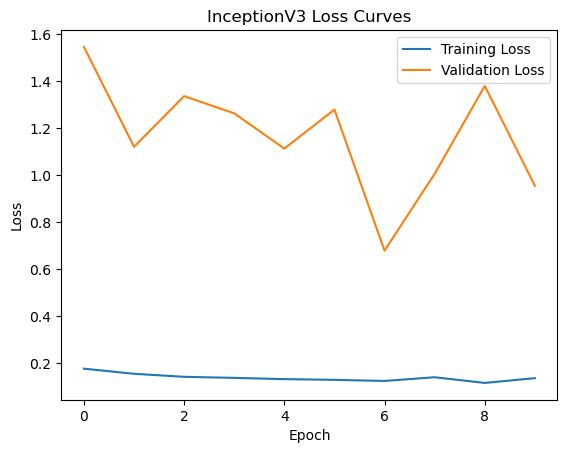

In [44]:
plot_loss_curves(inception_history.history['loss'], inception_history.history['val_loss'], "InceptionV3 Loss Curves")

Epoch 1/10
33/33 [==============================] - 56s 2s/step - loss: 0.1884 - accuracy: 0.9553 - val_loss: 1.3920 - val_accuracy: 0.5489
Epoch 2/10
33/33 [==============================] - 50s 2s/step - loss: 0.1822 - accuracy: 0.9553 - val_loss: 1.4516 - val_accuracy: 0.5489
Epoch 3/10
33/33 [==============================] - 52s 2s/step - loss: 0.1964 - accuracy: 0.9553 - val_loss: 1.8927 - val_accuracy: 0.5489
Epoch 4/10
33/33 [==============================] - 54s 2s/step - loss: 0.1858 - accuracy: 0.9553 - val_loss: 1.1075 - val_accuracy: 0.5489
Epoch 5/10
33/33 [==============================] - 53s 2s/step - loss: 0.1862 - accuracy: 0.9553 - val_loss: 1.4223 - val_accuracy: 0.5489
Epoch 6/10
33/33 [==============================] - 53s 2s/step - loss: 0.1844 - accuracy: 0.9553 - val_loss: 1.2592 - val_accuracy: 0.5489
Epoch 7/10
33/33 [==============================] - 61s 2s/step - loss: 0.1834 - accuracy: 0.9553 - val_loss: 1.6587 - val_accuracy: 0.5489
Epoch 8/10
33/33 [==

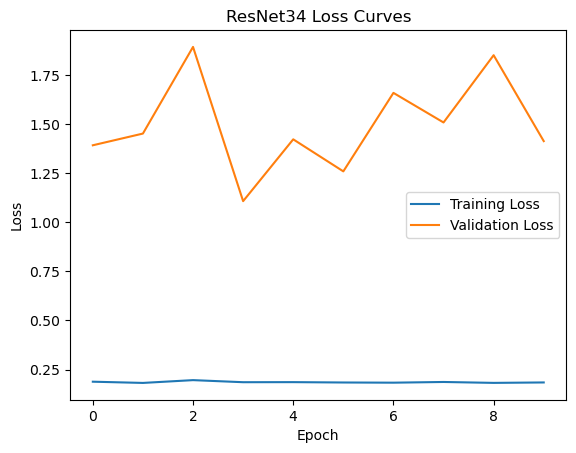

In [45]:
# Compile the ResNet34 model with loss metric
resnet_model_final.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Train the ResNet34 model
resnet_history = resnet_model_final.fit(
    train_covid_generator,
    steps_per_epoch=len(train_covid_generator),
    epochs=epochs,
    validation_data=test_covid_generator,
    validation_steps=len(test_covid_generator)
)

# Plot loss curves for ResNet34
plot_loss_curves(resnet_history.history['loss'], resnet_history.history['val_loss'], "ResNet34 Loss Curves")


Epoch 1/10
33/33 [==============================] - 75s 2s/step - loss: 0.1323 - accuracy: 0.9611 - val_loss: 1.2601 - val_accuracy: 0.5978
Epoch 2/10
33/33 [==============================] - 62s 2s/step - loss: 0.1085 - accuracy: 0.9630 - val_loss: 0.5223 - val_accuracy: 0.7444
Epoch 3/10
33/33 [==============================] - 490s 15s/step - loss: 0.1273 - accuracy: 0.9601 - val_loss: 0.6967 - val_accuracy: 0.6933
Epoch 4/10
33/33 [==============================] - 55s 2s/step - loss: 0.0907 - accuracy: 0.9728 - val_loss: 0.9816 - val_accuracy: 0.6644
Epoch 5/10
33/33 [==============================] - 56s 2s/step - loss: 0.1063 - accuracy: 0.9660 - val_loss: 0.8146 - val_accuracy: 0.6911
Epoch 6/10
33/33 [==============================] - 64s 2s/step - loss: 0.0914 - accuracy: 0.9679 - val_loss: 1.0172 - val_accuracy: 0.6711
Epoch 7/10
33/33 [==============================] - 61s 2s/step - loss: 0.0803 - accuracy: 0.9747 - val_loss: 0.9203 - val_accuracy: 0.6844
Epoch 8/10
33/33 [

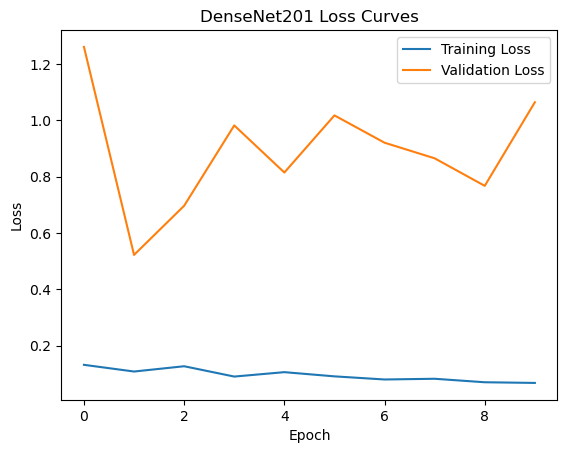

In [46]:

densenet_model_final.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])


densenet_history = densenet_model_final.fit(
    train_covid_generator,
    steps_per_epoch=len(train_covid_generator),
    epochs=epochs,
    validation_data=test_covid_generator,
    validation_steps=len(test_covid_generator)
)

# Plot loss curves 
plot_loss_curves(densenet_history.history['loss'], densenet_history.history['val_loss'], "DenseNet201 Loss Curves")


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [48]:
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int)
    true_labels = test_generator.classes
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, f1, specificity

In [49]:
inception_metrics = evaluate_model(inception_model_final, test_covid_generator)


15/15 [==============================] - 10s 572ms/step


In [50]:
resnet_metrics = evaluate_model(resnet_model_final, test_covid_generator)


15/15 [==============================] - 14s 871ms/step


In [51]:
densenet_metrics = evaluate_model(densenet_model_final, test_covid_generator)

15/15 [==============================] - 19s 1s/step


In [52]:
inception_metrics_1 = evaluate_model(inception_model_final, test_non_covid_generator)

15/15 [==============================] - 9s 596ms/step


In [53]:
resnet_metrics_1 = evaluate_model(resnet_model_final, test_non_covid_generator)


15/15 [==============================] - 13s 884ms/step


In [54]:
densenet_metrics_1 = evaluate_model(densenet_model_final, test_non_covid_generator)

15/15 [==============================] - 18s 1s/step


# To get the Accuracy, Precision, Recall, F1 Score, Specificity for the models

In [55]:
print("Metrics for COVID images:")
print("InceptionV3: Accuracy = {}, Precision = {}, Recall = {}, F1 Score = {}, Specificity = {}".format(*inception_metrics))
print("ResNet34: Accuracy = {}, Precision = {}, Recall = {}, F1 Score = {}, Specificity = {}".format(*resnet_metrics))
print("DenseNet201: Accuracy = {}, Precision = {}, Recall = {}, F1 Score = {}, Specificity = {}".format(*densenet_metrics))


Metrics for COVID images:
InceptionV3: Accuracy = 0.5622222222222222, Precision = 0.5565610859728507, Recall = 0.9959514170040485, F1 Score = 0.7140783744557329, Specificity = 0.034482758620689655
ResNet34: Accuracy = 0.5488888888888889, Precision = 0.5488888888888889, Recall = 1.0, F1 Score = 0.7087517934002869, Specificity = 0.0
DenseNet201: Accuracy = 0.5377777777777778, Precision = 0.5498721227621484, Recall = 0.8704453441295547, F1 Score = 0.6739811912225706, Specificity = 0.1330049261083744


In [56]:
print("Metrics for NON-COVID images:")
print("InceptionV3: Accuracy = {}, Precision = {}, Recall = {}, F1 Score = {}, Specificity = {}".format(*inception_metrics_1))
print("ResNet34: Accuracy = {}, Precision = {}, Recall = {}, F1 Score = {}, Specificity = {}".format(*resnet_metrics_1))
print("DenseNet201: Accuracy = {}, Precision = {}, Recall = {}, F1 Score = {}, Specificity = {}".format(*densenet_metrics_1))

Metrics for NON-COVID images:
InceptionV3: Accuracy = 0.54, Precision = 0.5452488687782805, Recall = 0.9757085020242915, F1 Score = 0.6995645863570391, Specificity = 0.009852216748768473
ResNet34: Accuracy = 0.5488888888888889, Precision = 0.5488888888888889, Recall = 1.0, F1 Score = 0.7087517934002869, Specificity = 0.0
DenseNet201: Accuracy = 0.5511111111111111, Precision = 0.5575447570332481, Recall = 0.8825910931174089, F1 Score = 0.6833855799373041, Specificity = 0.1477832512315271


# Value of Accuracy,Precision,Recall,F1 Score,Specificity for the Ensemble Model

In [57]:
ensemble_labels = (avg_preds > 0.5).astype(int)

In [58]:
true_labels = test_covid_generator.classes

In [59]:
ensemble_accuracy = accuracy_score(true_labels, ensemble_labels)
ensemble_precision = precision_score(true_labels, ensemble_labels)
ensemble_recall = recall_score(true_labels, ensemble_labels)
ensemble_f1 = f1_score(true_labels, ensemble_labels)
tn, fp, fn, tp = confusion_matrix(true_labels, ensemble_labels).ravel()
ensemble_specificity = tn / (tn + fp)


In [60]:
print("Metrics for Ensemble Model:")
print("Accuracy = {}, Precision = {}, Recall = {}, F1 Score = {}, Specificity = {}".format(ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1, ensemble_specificity))

Metrics for Ensemble Model:
Accuracy = 0.5488888888888889, Precision = 0.5488888888888889, Recall = 1.0, F1 Score = 0.7087517934002869, Specificity = 0.0
